In [3]:
# Importing libraries
# type: ignore
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.colors as mcolors
import json
from matplotlib.colors import LinearSegmentedColormap



import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import LineString

# CMU Colors

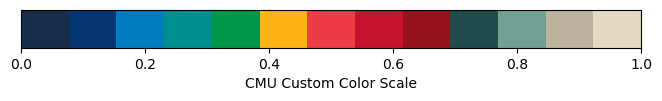

In [4]:
# CMU color scale in HEX
cmu_gradient_colors = [
    "#182C4B",  # Deep Blue (Weaver Blue)
    "#043673",  # Dark Blue (CMU Blue)
    "#007BC0",  # Sky Blue (Highlands Sky)
    "#008F91",  # Teal
    "#009647",  # Green Thread
    "#FDB515",  # Gold Thread
    "#EF3A47",  # Scots Rose (Bright Red)
    "#C41230",  # CMU Red
    "#941120",  # Dark Red (Skibo Red)
    "#1F4C4C",  # Deep Green (Hornbostel Teal)
    "#719F94",  # Palladian Green
    "#BCB49E",  # Soft Tan
    "#E4DAC4"   # Light Beige
]

# ListedColormap
cmu_cmap = mcolors.ListedColormap(cmu_gradient_colors, name="cmu_scale")

# Display color scale
fig, ax = plt.subplots(figsize=(8, 1))
fig.subplots_adjust(bottom=0.5)

# Create color bar
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=cmu_cmap, norm=plt.Normalize(vmin=0, vmax=1)),
    cax=ax,
    orientation="horizontal"
)
cbar.set_label("CMU Custom Color Scale")

plt.show()

# Loading Files 

In [5]:
# Load Data
geo_points_df = gpd.read_file('facilities_points_rw.geojson')
dist_gdf = gpd.read_file('District_Boundaries.geojson')
pop_df = pd.read_csv('rw_population.csv')

# Convert Districts to UTM (EPSG:32736)
if dist_gdf.crs is None or dist_gdf.crs.is_geographic:
    dist_gdf = dist_gdf.to_crs(epsg=32736)

# Convert Health Facilities to UTM (MUST MATCH DISTRICTS)
if geo_points_df.crs is None or geo_points_df.crs.is_geographic:
    geo_points_df = geo_points_df.to_crs(epsg=32736)

# Compute area, centroid, and boundaries
dist_gdf["area_km2"] = dist_gdf.area / 1e6
dist_gdf["Centroid"] = dist_gdf.centroid
dist_gdf["boundary"] = dist_gdf.boundary

# Copy Data
gdf = dist_gdf.copy()

# Check available facility types
print("Available facilities:", geo_points_df['healthcare'].unique())

# Define main facility types
main_facility = ['clinic', 'hospital', 'pharmacy', 'alternative', 'laboratory']
num_facilities = len(main_facility)

# Color Palette
colors = [
    "#FDB515", "#941120", "#1F4C4C", "#009647", "#043673", "#EF3A47"
]

# Print json of ditsricts and their surface areas
districts_areas = gdf[['district', 'area_km2']]
json_districts_areas = districts_areas.to_json(orient='records')
json_districts_areas


Available facilities: ['clinic' None 'dentist' 'hospital' 'pharmacy' 'centre' 'nurse'
 'alternative' 'yes' 'laboratory' 'doctor']


'[{"district":"Nyarugenge","area_km2":132.7138683285},{"district":"Gasabo","area_km2":429.9924431912},{"district":"Kicukiro","area_km2":167.304572214},{"district":"Nyanza","area_km2":672.9843681981},{"district":"Gisagara","area_km2":675.873665238},{"district":"Nyaruguru","area_km2":1010.1218744448},{"district":"Huye","area_km2":582.5331108173},{"district":"Nyamagabe","area_km2":1094.3277979342},{"district":"Ruhango","area_km2":627.4289820127},{"district":"Muhanga","area_km2":648.2251327677},{"district":"Kamonyi","area_km2":661.2415284063},{"district":"Karongi","area_km2":791.1865160255},{"district":"Rutsiro","area_km2":663.9300324821},{"district":"Rubavu","area_km2":338.2852731728},{"district":"Nyabihu","area_km2":539.3720296517},{"district":"Ngororero","area_km2":678.3853571035},{"district":"Rusizi","area_km2":920.4546495376},{"district":"Nyamasheke","area_km2":952.3449046624},{"district":"Rulindo","area_km2":568.4426559017},{"district":"Gakenke","area_km2":705.6059949453},{"district"

# Ploting Maps 

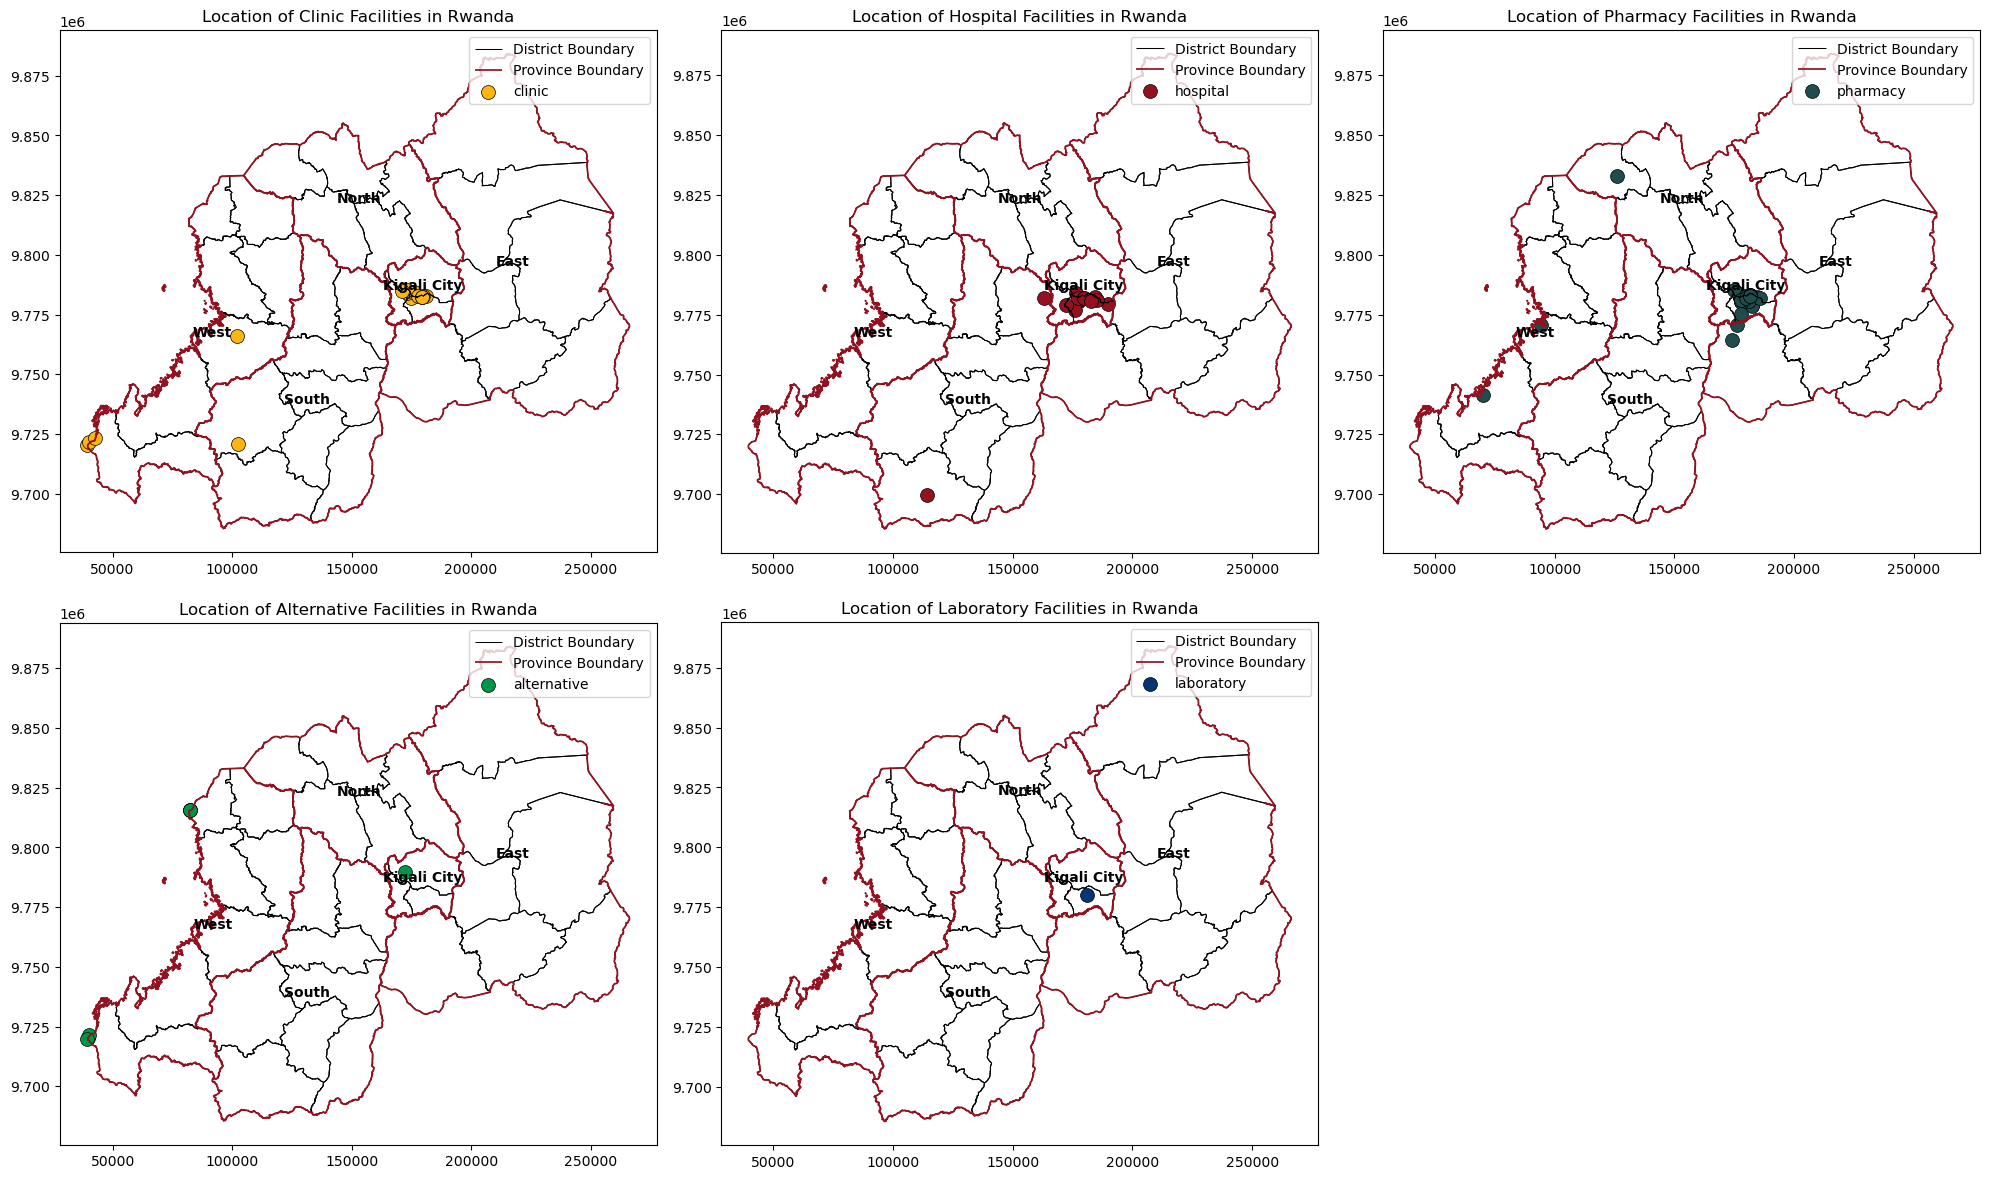

In [6]:
# How are different types of healthcare facilities distributed across Rwanda?


# Grid of subplots
rows = 2
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
axes = axes.flatten()

# Dissolve districts to get province boundaries and compute centroids
province_gdf = gdf.dissolve(by='prov_code', as_index=False)
province_gdf["Centroid"] = province_gdf.geometry.centroid

# Loop through each facility type and create a plot
for i, facility in enumerate(main_facility):
    ax = axes[i]

    # Plot District and Province Boundaries
    gdf.boundary.plot(ax=ax, color='black', linewidth=0.75, label='District Boundary')
    province_gdf.boundary.plot(ax=ax, color='#941120', linewidth=1.25, label='Province Boundary')

    # let's annotate each province **only once** at its centroid
    for idx, row in province_gdf.iterrows():
        if row["Centroid"] is not None:
            ax.annotate(text=row["province_eng"], 
                        xy=(row["Centroid"].x, row["Centroid"].y), 
                        ha='center', fontsize=10, fontweight='bold', color='black')

    # flitering the health facilities for the selected type
    facility_gdf = geo_points_df[geo_points_df['healthcare'] == facility]

    # let's ensure facility_gdf is not empty before plotting
    if not facility_gdf.empty:
        facility_gdf.plot(ax=ax, color=colors[i], markersize=100, label=facility, 
                          legend=True, edgecolor='black', linewidth=0.5)
    else:
        print(f"⚠️ Warning: No data found for {facility}")

    # Set title
    ax.set_title(f"Location of {facility.capitalize()} Facilities in Rwanda", fontsize=12)

    # Add legend
    ax.legend()

# Hide unused subplots
for j in range(i + 1, rows * cols):
    axes[j].axis('off')

# adjusting the layout
plt.tight_layout()

# showing the plot
plt.show()

The visualizations reveal how different types of healthcare facilities are distributed across Rwanda. 

The analysis of healthcare facility distribution across Rwanda reveals a significant concentration of hospitals, pharmacies, and laboratories in Kigali City, while rural areas, particularly the North, South, and West, have fewer specialized healthcare facilities. This urban bias suggests that individuals in rural communities may face limited access to advanced medical care, highlighting disparities in healthcare infrastructure. Such a pattern underscores the need for a data-driven, need-based approach to healthcare resource allocation, ensuring that facilities are distributed more equitably.

In rural provinces, particularly in the West and North, hospitals and laboratories are notably sparse. Instead, these regions have a higher prevalence of clinics and alternative medicine centers, which may indicate that formal healthcare infrastructure is insufficient, leading residents to rely on traditional medicine practices. This raises an important question—are these facilities filling an essential gap in medical services, or do these regions lack access to modern healthcare options? Addressing this concern through policy adjustments and infrastructure investments could significantly improve healthcare accessibility.

One of the most striking observations is the limited presence of healthcare facilities in Western Rwanda. Despite its geographic size and population, the West has fewer pharmacies, laboratories, and hospitals than other provinces. This disparity suggests that current facility placement may not be driven by population density or disease burden, which could negatively impact health outcomes in these communities. The lack of specialized medical services in these areas also raises concerns about access to emergency healthcare and essential medications.

Finally, an interesting pattern emerges when analyzing alternative medicine centers, which appear more evenly distributed across the country compared to hospitals and pharmacies. This suggests that traditional medicine may play a critical role in healthcare accessibility in regions where formal healthcare is scarce. Understanding the reasons behind this distribution—whether due to cultural healthcare preferences or gaps in access to modern medicine—could inform health policy improvements and resource allocation strategies.

### Map with all facilities.

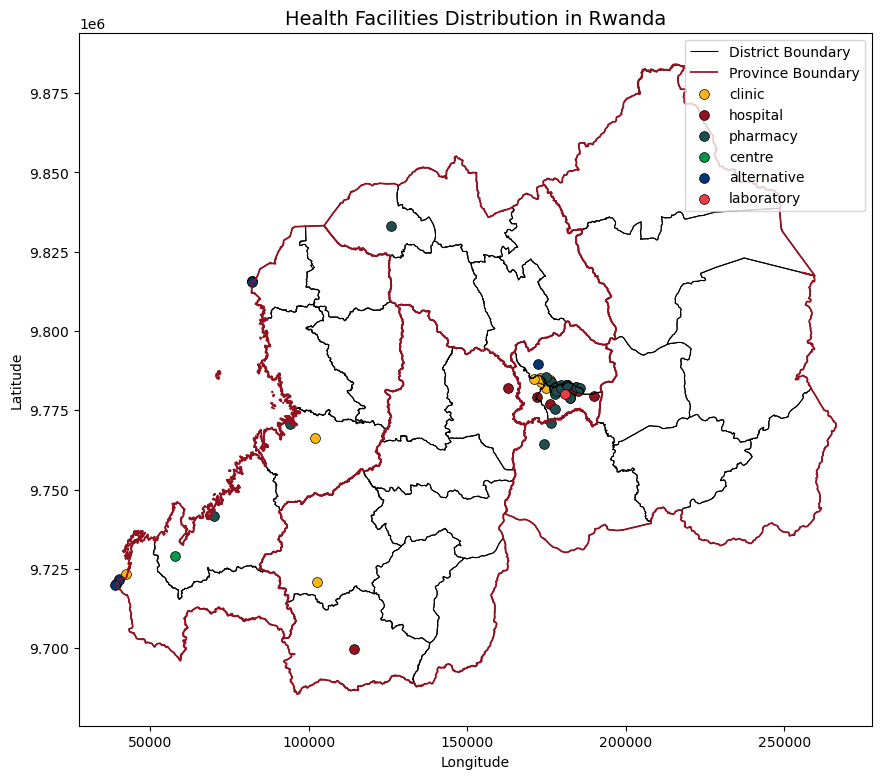

In [7]:
# Define color mapping for facility types
facility_colors = {
    "clinic": "#FDB515",       # Gold
    "hospital": "#941120",     # Dark Red
    "pharmacy": "#1F4C4C",     # Deep Green
    "centre": "#009647",       # Green Thread
    "alternative": "#043673",  # CMU Blue
    "laboratory": "#EF3A47"    # Scots Rose (Bright Red)
}

# Map of Rwanda with color-coded health facilities
fig, ax = plt.subplots(figsize=(20, 9))

# Plot district and province boundaries
gdf.boundary.plot(ax=ax, color='black', linewidth=0.75, label='District Boundary')
province_gdf.boundary.plot(ax=ax, color='#941120', linewidth=1.25, label='Province Boundary')

# looping through facility types and plot each with a different color
for facility, color in facility_colors.items():
    facility_subset = geo_points_df[geo_points_df['healthcare'] == facility]
    if not facility_subset.empty:
        facility_subset.plot(ax=ax, color=color, markersize=50, label=facility, 
                             edgecolor='black', linewidth=0.5)

# Formatting
ax.set_title("Health Facilities Distribution in Rwanda", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

# Show plot
plt.show()

# Population Density 

In [18]:
# dist_gdf.columns

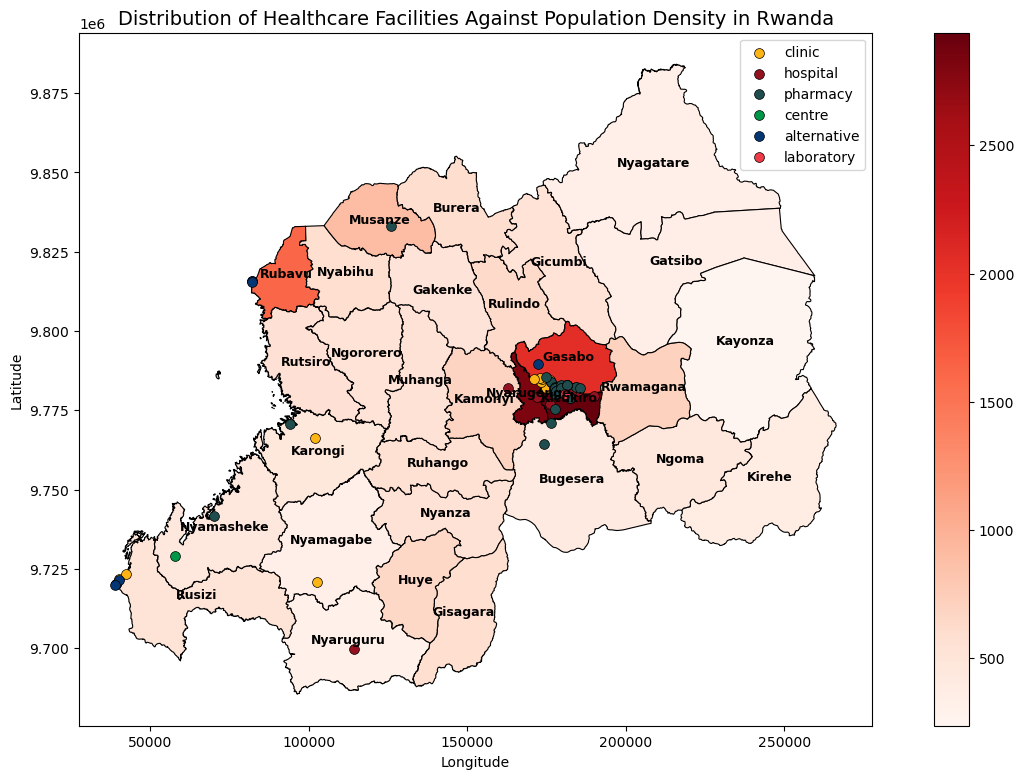

In [19]:
# Are healthcare facilities placed where people need them most?

# Ensure CRS consistency for health facilities
if geo_points_df.crs is None or geo_points_df.crs.is_geographic:
    geo_points_df = geo_points_df.to_crs(epsg=32736)

# Define color mapping for facility types
facility_colors = {
    "clinic": "#FDB515",       # Gold
    "hospital": "#941120",     # Dark Red
    "pharmacy": "#1F4C4C",     # Deep Green
    "centre": "#009647",       # Green Thread
    "alternative": "#043673",  # CMU Blue
    "laboratory": "#EF3A47"    # Scots Rose (Bright Red)
}

# creating the Choropleth Map of Population Density with Facility Overlay
fig, ax = plt.subplots(figsize=(16, 9))

gdf['population'] = gdf['district'].map(pop_df.set_index('District')['Population'])
gdf['population_density'] = gdf['population'] / gdf['area_km2']
dist_gdf = gdf.copy()

# Compute population density (people per km²)
# dist_gdf["population_density"] = dist_gdf["population"] / dist_gdf["area_km2"]

# Plot Population Density as a Choropleth Map
dist_gdf.plot(column="population_density", cmap="Reds", linewidth=0.8, edgecolor="black", legend=True, ax=ax)

# Plot healthcare facilities, color-coded by type
for facility, color in facility_colors.items():
    facility_subset = geo_points_df[geo_points_df['healthcare'] == facility]
    if not facility_subset.empty:
        facility_subset.plot(ax=ax, color=color, markersize=50, label=facility, edgecolor='black', linewidth=0.5)

# Add district names at their centroids
for idx, row in dist_gdf.iterrows():
    ax.annotate(text=row["district"], xy=(row["Centroid"].x, row["Centroid"].y), 
                ha="center", fontsize=9, fontweight="bold", color="black")

# Formatting
ax.set_title("Distribution of Healthcare Facilities Against Population Density in Rwanda", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

# Show Plot
plt.show()

The visualization overlays healthcare facility locations on a population density of Rwanda, to provide a clear comparison of whether facilities are placed where people need them most.

The analysis reveals that healthcare facilities are heavily concentrated in Kigali, particularly in Gasabo, Kicukiro, and Nyarugenge districts. This pattern aligns with Kigali’s status as the most densely populated area, where demand for healthcare services is highest. However, the over-concentration of hospitals, pharmacies, and clinics in Kigali suggests an imbalance in healthcare distribution. While urban areas require more facilities, the disproportionate allocation in Kigali compared to other high-density districts indicates a potential resource misalignment that may leave rural and peri-urban areas underserved.

Several high-population districts outside Kigali, such as Rubavu, Musanze, and Rwamagana, appear to have fewer healthcare facilities than expected. In the Eastern Province, Nyagatare, Kirehe, and Gatsibo also stand out as districts with significant populations but a low number of hospitals and clinics. These findings indicate that, while healthcare facilities are present, they may not be optimally distributed based on population demand. Expanding medical infrastructure in these areas could help reduce overcrowding in Kigali’s hospitals and improve healthcare accessibility for a broader population.

Rural and border districts, particularly in Western and Southern Rwanda (Nyamasheke, Rusizi, Nyamagabe, and Gisagara), show sparse healthcare access despite moderate population density. Many remote areas rely on only a handful of clinics or alternative medicine centers, suggesting that traditional medicine may be supplementing gaps in formal healthcare infrastructure. The limited presence of hospitals and pharmacies in these regions raises concerns about delays in emergency care and access to essential medications. If residents must travel long distances to reach the nearest medical facility, it could lead to higher rates of untreated illnesses and health complications.

In [20]:
# dist_gdf.columns

# Disease Prevelence Analysis 

To investigate whether healthcare facilities align with disease prevalence, we will: 
1. Process disease data (Tuberculosis, Malaria, HIV)
2. Map disease burden across Rwanda
3. Overlay healthcare facilities to identify gaps and mismatches

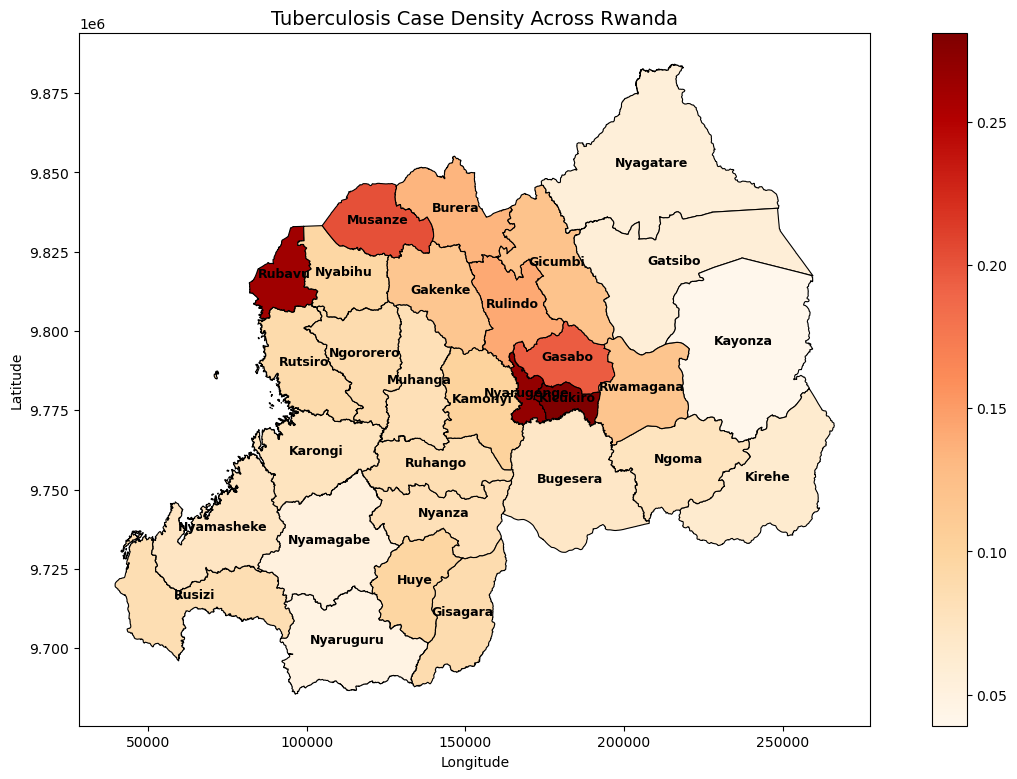

In [22]:
# Do healthcare facilities align with disease prevalence? Specifically, are hospitals, clinics, and pharmacies located in districts with high rates of Tuberculosis (TB)?

# Compute total population for each province
province_population = dist_gdf.groupby('province')['population'].sum().reset_index()
province_population.columns = ['province', 'total_population']

# Merge province-level total population back to the district data
dist_gdf = dist_gdf.merge(province_population, on='province', suffixes=('', '_total'))

# Compute the population ratio (district population / total population of province)
dist_gdf['dist_pop_ratio'] = dist_gdf['population'] / dist_gdf['total_population']

# Compute district areas (convert from square meters to square kilometers)
dist_gdf["area_km2"] = dist_gdf.geometry.area / 1e6

# Load Tuberculosis (TB) data from JSON file
with open("tuberculosis_data.json", "r") as file:
    tb_data = json.load(file) 

# Convert JSON data to DataFrame
tb_df = pd.DataFrame(tb_data).T  # Transpose for proper structure

# Compute total TB cases (sum of male & female cases)
tb_df['total_tb_cases'] = tb_df['women_number_with_symptom'] + tb_df['men_number_with_symptom']

# Reset index and rename column to match province names in the main dataset
tb_df.reset_index(inplace=True)
tb_df.rename(columns={'index': 'category'}, inplace=True)

# Create a copy of the district dataset for disease analysis
disease_gdf = dist_gdf.copy()

# Merge TB data into the district dataset based on province mapping
disease_gdf['tb_dist_cases'] = disease_gdf['province_eng'].map(tb_df.set_index('category')['total_tb_cases']) * disease_gdf['dist_pop_ratio']

# Compute TB case density per km²
disease_gdf['tb_density'] = disease_gdf['tb_dist_cases'] / disease_gdf['area_km2']

# Plot TB Case Density Heatmap
fig, ax = plt.subplots(figsize=(16, 9))
disease_gdf.plot(column="tb_density", cmap="OrRd", linewidth=0.8, edgecolor="black", legend=True, ax=ax)

# Add district names at their centroids
for idx, row in disease_gdf.iterrows():
    ax.annotate(text=row["district"], xy=(row.geometry.centroid.x, row.geometry.centroid.y), 
                ha="center", fontsize=9, fontweight="bold", color="black")

# Formatting
ax.set_title("Tuberculosis Case Density Across Rwanda", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show Plot
plt.show()

In [ ]:
# disease_gdf.head()

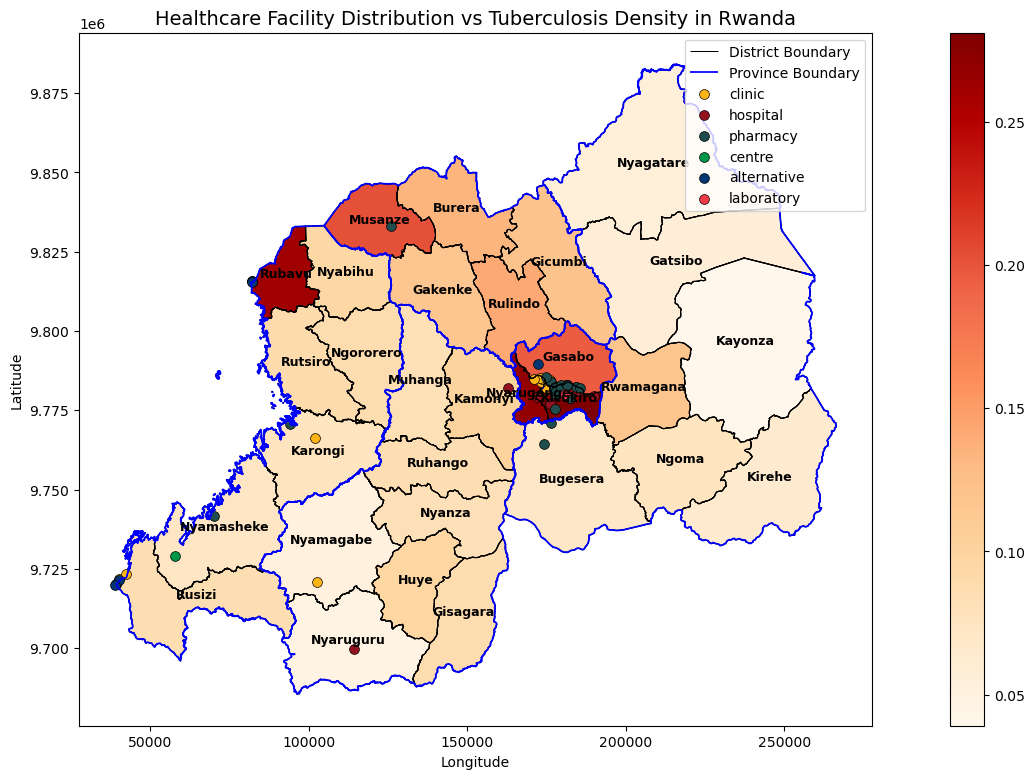

In [23]:

# Define color mapping for different healthcare facility types
facility_colors = {
    "clinic": "#FDB515",       # Gold
    "hospital": "#941120",     # Dark Red
    "pharmacy": "#1F4C4C",     # Deep Green
    "centre": "#009647",       # Green Thread
    "alternative": "#043673",  # CMU Blue
    "laboratory": "#EF3A47"    # Scots Rose (Bright Red)
}

# Create a TB Density Heatmap with Healthcare Facility Overlay
fig, ax = plt.subplots(figsize=(20, 9))

# Plot TB Density as a Choropleth Map
disease_gdf.plot(column="tb_density", cmap="OrRd", linewidth=0.8, edgecolor="black", legend=True, ax=ax)

# Outline district and province borders
dist_gdf.boundary.plot(ax=ax, color="black", linewidth=0.75, label="District Boundary")
province_population_gdf = dist_gdf.dissolve(by='province')
province_population_gdf.boundary.plot(ax=ax, color="blue", linewidth=1.25, label="Province Boundary")

# Plot healthcare facilities with different colors
for facility, color in facility_colors.items():
    facility_subset = geo_points_df[geo_points_df['healthcare'] == facility]
    if not facility_subset.empty:
        facility_subset.plot(ax=ax, color=color, markersize=50, label=facility, edgecolor='black', linewidth=0.5)

# Add district names at their centroids
for idx, row in disease_gdf.iterrows():
    ax.annotate(text=row["district"], xy=(row.geometry.centroid.x, row.geometry.centroid.y), 
                ha="center", fontsize=9, fontweight="bold", color="black")

# Formatting
ax.set_title("Healthcare Facility Distribution vs Tuberculosis Density in Rwanda", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

# Show Plot
plt.show()

The analysis of healthcare facility distribution in relation to tuberculosis (TB) prevalence in Rwanda highlights critical disparities in the allocation of medical resources. The heatmap visualizing TB case density across districts provides a clear picture of regions with the highest burden of the disease. Overlaying the locations of hospitals, clinics, pharmacies, and other healthcare facilities allows us to assess whether resources are positioned effectively to address disease prevalence.

1. Districts with High TB Density and Facility Availability
The heatmap reveals that Musanze, Rubavu, Gasabo, and Rwamagana exhibit the highest TB case density per km². These districts are characterized by moderate to high population densities, making them hotspots for disease transmission. Encouragingly, Gasabo and Rwamagana, both located in the Kigali metropolitan area, have a higher concentration of healthcare facilities, including hospitals, clinics, and pharmacies. This suggests that, at least in these urbanized regions, healthcare access may be aligned with public health needs.


    However, in Musanze and Rubavu, while TB prevalence is high, the distribution of healthcare facilities appears sparse in comparison. The limited number of hospitals and clinics in these areas may indicate a gap in accessibility for TB diagnosis and treatment, which could contribute to delays in healthcare-seeking behavior and increased disease spread.

2. Districts with High TB Density but Fewer Healthcare Facilities
Regions such as Ngoma, Kayonza, and Karongi show moderate TB prevalence but have fewer healthcare facilities. This imbalance suggests a potential misalignment between healthcare infrastructure and disease burden. Given that TB requires early detection and continuous medical follow-up, these areas may benefit from additional diagnostic centers, mobile clinics, or increased resource allocation to existing healthcare facilities.

    Furthermore, rural districts with limited facilities (e.g., Nyaruguru, Nyamasheke, and Rusizi) may experience significant barriers to TB treatment access. Patients from these regions may need to travel long distances to seek specialized TB care, which could delay diagnosis and lead to worse health outcomes.

3. Districts with Low TB Density but High Facility Concentration
Interestingly, districts like Kicukiro and Nyarugenge (within Kigali) have a high concentration of healthcare facilities but relatively lower TB density. This highlights the effect of urban infrastructure and healthcare accessibility—individuals in densely populated urban centers tend to have better access to diagnostics, treatment, and preventive healthcare measures. However, this also suggests a potential overconcentration of medical resources in Kigali at the expense of rural areas.

In [ ]:
# Which regions in Rwanda have the lowest rates of people seeking care for Tuberculosis (TB)?



### Malaria Prevalence


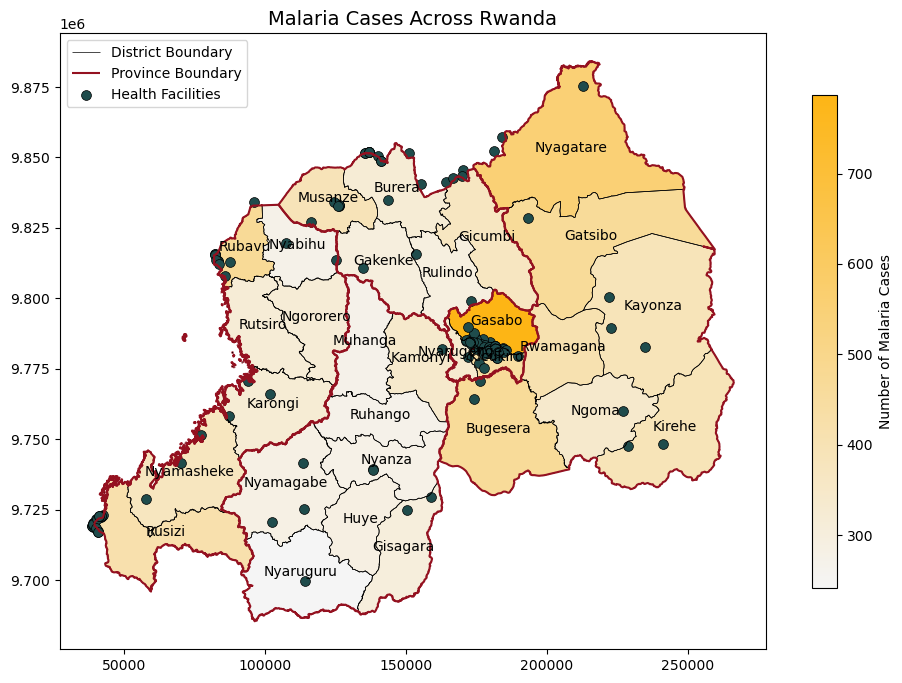

In [25]:
# Load malaria dataset
malaria_df = pd.read_csv('rw_malaria.csv')

# Compute total malaria cases
malaria_df['total_malaria_cases'] = malaria_df['num_of_women'] + malaria_df['num_of_children']

# Merge malaria data into district dataset
disease_gdf['malaria_dist_cases'] = disease_gdf['province_eng'].map(malaria_df.set_index('province')['total_malaria_cases']) * disease_gdf['dist_pop_ratio']
disease_gdf['malaria_density'] = disease_gdf['malaria_dist_cases'] / disease_gdf['area_km2']

# Define the gradient for the colormap
gradient = ["#F5F5F5", "#FDB515"]
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", gradient)

# Create a single figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot district boundaries
disease_gdf.boundary.plot(ax=ax, color="black", linewidth=0.5, label='District Boundary')

# Plot malaria cases as a heatmap
disease_gdf.plot(column="malaria_dist_cases", ax=ax, cmap=custom_cmap, legend=True, 
                 legend_kwds={"label": "Number of Malaria Cases", "shrink": 0.8})

# Plot province boundaries
province_gdf.boundary.plot(ax=ax, color='#941120', linewidth=1.5, label='Province Boundary')

# Add district names as annotations
for idx, row in disease_gdf.iterrows():
    ax.annotate(text=row["district"], 
                xy=[row["Centroid"].x, row["Centroid"].y], 
                ha='center', fontsize=10, color='black')

# Plot health facilities
geo_points_df.plot(ax=ax, color='#1F4C4C', markersize=50, label='Health Facilities', 
                   edgecolor='black', linewidth=0.5)

# Formatting
ax.set_title("Malaria Cases Across Rwanda", fontsize=14)
ax.legend()

# Show Plot
plt.show()

The Malaria Cases Across Rwanda heatmap provides valuable insights into the spatial distribution of malaria cases and their correlation with healthcare facility placement. The visualization highlights districts with the highest malaria burden while also depicting the distribution of healthcare facilities.

1. High Malaria Prevalence in the Eastern and Northern Regions
From the map, Nyagatare, Gasabo, and Gatsibo districts exhibit the highest malaria case counts, as indicated by the darker yellow shading. These regions are among the most populated areas in Rwanda, which could explain the high reported malaria cases. Additionally, these areas have large agricultural zones and wetlands, which are known to be breeding grounds for malaria-transmitting mosquitoes.

2. Healthcare Facilities Concentration vs. Malaria Burden
The placement of healthcare facilities (green dots) shows a heavy concentration around Kigali and major urban centers, while the rural and high-malaria districts (e.g., Nyagatare, Gatsibo, and Kirehe) have fewer healthcare facilities. This suggests that malaria treatment services may be limited in high-burden areas, potentially delaying access to care for affected populations.

3. Western and Southern Rwanda: Lower Malaria Burden
Districts in the Western Province (e.g., Rusizi, Nyamasheke, and Karongi) and parts of the Southern Province (e.g., Nyamagabe, Nyaruguru) show relatively lower malaria cases. This could be due to higher elevation and cooler climates, which are less favorable for mosquito breeding. These areas, despite having fewer malaria cases, still show a notable number of healthcare facilities.

4. Urban vs. Rural Disparities
Urban centers such as Gasabo and Kigali have better access to healthcare but still experience significant malaria cases due to high population density and mobility. In contrast, rural areas like Bugesera and Kayonza, where malaria burden is moderate, seem to have fewer healthcare facilities relative to their population size, indicating potential gaps in service provision.